<a href="https://colab.research.google.com/github/Daps2831/Machine-Learning/blob/main/Clustering_UTS_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#  1. pipeline end-to-end

## a.Pengumpulan & pembersihan data (Pandas)  

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import numpy as np


In [3]:
# Ganti path sesuai lokasi file di Google Drive
file_path = "/content/drive/MyDrive/Dataset/UTSClustering.csv"
# Membaca file Excel
shutil.copy(file_path, '/content/UTSClustering.csv')
data = pd.read_csv(file_path, encoding='ISO-8859-1')


In [4]:
# Show the first few rows of the dataset to understand its structure
print("Original Data:")
print(data.head())

# 1. Remove Duplicate Rows
data_cleaned = data.drop_duplicates()

# 2. Handle Missing Values
# Drop rows where critical columns (InvoiceNo, StockCode, Quantity, UnitPrice) are missing
data_cleaned = data_cleaned.dropna(subset=['InvoiceNo', 'StockCode', 'Quantity', 'UnitPrice'])

# Fill missing values in non-critical columns (like 'Country') with a placeholder 'Unknown'
data_cleaned['Country'].fillna('Unknown', inplace=True)

# 3. Convert 'InvoiceDate' to DateTime format
data_cleaned['InvoiceDate'] = pd.to_datetime(data_cleaned['InvoiceDate'], errors='coerce')

# 4. Convert 'Quantity' and 'UnitPrice' to numeric values, coercing errors to NaN
data_cleaned['Quantity'] = pd.to_numeric(data_cleaned['Quantity'], errors='coerce')
data_cleaned['UnitPrice'] = pd.to_numeric(data_cleaned['UnitPrice'], errors='coerce')

# 5. Remove rows with invalid (NaN) values after conversion of 'Quantity' and 'UnitPrice'
data_cleaned = data_cleaned.dropna(subset=['Quantity', 'UnitPrice'])

# 6. Remove rows with negative or zero values in 'Quantity' or 'UnitPrice'
data_cleaned = data_cleaned[(data_cleaned['Quantity'] > 0) & (data_cleaned['UnitPrice'] > 0)]

# Show the cleaned data
print("\nCleaned Data:")
print(data_cleaned.head())

# Optionally, save the cleaned dataset to a new file
# data_cleaned.to_csv('/mnt/data/Cleaned_UTSClustering.csv', index=False)


Original Data:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


<ipython-input-4-ee6d08150ef9>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_cleaned['Country'].fillna('Unknown', inplace=True)



Cleaned Data:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


## b.Feature Selection

In [5]:
from sklearn.feature_selection import VarianceThreshold

# 1. **Remove Constant and Quasi-Constant Features**
# VarianceThreshold is used to remove features with low variance (constant/quasi-constant features)
# Select only numerical features for variance analysis
numerical_features = data_cleaned.select_dtypes(include=['number']).columns

selector = VarianceThreshold(threshold=0.01)  # Threshold can be adjusted (0.01 for quasi-constant features)
data_no_constant = selector.fit_transform(data_cleaned[numerical_features].dropna(axis=1, how='all'))

# Show which features were retained after removing constant/quasi-constant features
kept_columns = numerical_features[selector.get_support()]
print("Features retained after removing constant/quasi-constant features:", kept_columns)

Features retained after removing constant/quasi-constant features: Index(['Quantity', 'UnitPrice', 'CustomerID'], dtype='object')


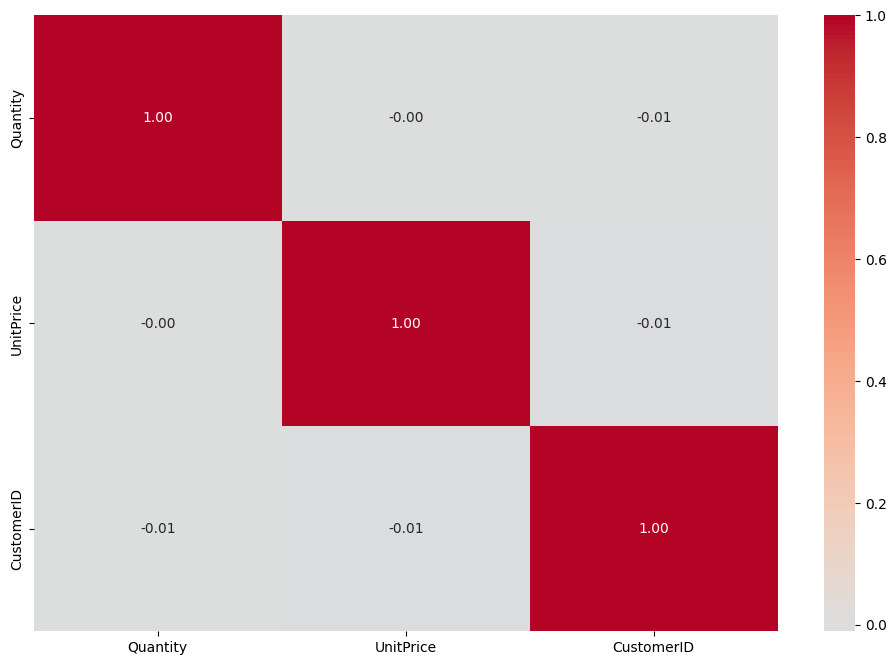


Columns after removing highly correlated features: Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


In [6]:
# 2. **Remove Highly Correlated Features**
# Calculate the correlation matrix to identify highly correlated features
correlation_matrix = data_cleaned[kept_columns].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.show()

# Remove highly correlated features (correlation > 0.95)
threshold = 0.95
corr_matrix = correlation_matrix.abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

# Drop the highly correlated features
data_cleaned_no_corr = data_cleaned.drop(to_drop, axis=1)
print("\nColumns after removing highly correlated features:", data_cleaned_no_corr.columns)

In [7]:
# 3. **Feature Selection Based on Variance (VarianceThreshold)**
# This removes features with low variance, as they do not contribute much information.
# Select only numerical features for variance analysis
numerical_features = data_cleaned_no_corr.select_dtypes(include=['number']).columns

variance_selector = VarianceThreshold(threshold=0.01)  # You can change the threshold value
data_no_variance = variance_selector.fit_transform(data_cleaned_no_corr[numerical_features])

# Show features retained after variance-based feature selection
# Use numerical_features to get the correct column names after transformation
final_selected_columns = numerical_features[variance_selector.get_support()]
print("\nFinal selected features after variance thresholding:", final_selected_columns)

# Final data after feature selection
data_final_selected = data_cleaned_no_corr[final_selected_columns]
print("\nShape of final dataset:", data_final_selected.shape)


Final selected features after variance thresholding: Index(['Quantity', 'UnitPrice', 'CustomerID'], dtype='object')

Shape of final dataset: (524878, 3)


## Feature Engineering

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA

# Assuming 'data_cleaned' is the dataset that is already cleaned

# 1. **Log Transformation** (for skewed numeric features)
# Apply log transformation to features like 'UnitPrice' if they are heavily skewed
data_cleaned['UnitPrice_log'] = np.log1p(data_cleaned['UnitPrice'])

# 2. **Standardisasi** (Standard Scaling - Z-score normalization)
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data_cleaned.select_dtypes(include=[np.number]))  # Standardize numeric features

# Convert back to DataFrame if necessary
data_standardized_df = pd.DataFrame(data_standardized, columns=data_cleaned.select_dtypes(include=[np.number]).columns)

# 3. **Normalisasi** (Min-Max Scaling - Scaling features to range [0, 1])
min_max_scaler = MinMaxScaler()
data_normalized = min_max_scaler.fit_transform(data_cleaned.select_dtypes(include=[np.number]))  # Normalize numeric features

# Convert back to DataFrame if necessary
data_normalized_df = pd.DataFrame(data_normalized, columns=data_cleaned.select_dtypes(include=[np.number]).columns)

# 4. **One-Hot Encoding** (For categorical features)
# One-hot encode categorical columns (like 'Country')
data_one_hot = pd.get_dummies(data_cleaned['Country'], prefix='Country')
data_cleaned = pd.concat([data_cleaned, data_one_hot], axis=1)

# 5. **Label Encoding** (For categorical features with an ordinal relationship)
# Label encode the 'Country' column if it has an ordinal relationship (e.g., 'Low', 'Medium', 'High')
label_encoder = LabelEncoder()
data_cleaned['Country_encoded'] = label_encoder.fit_transform(data_cleaned['Country'])

# Display the transformed data
print("Data after log transformation, scaling, encoding:")
print(data_cleaned.head())

# Optionally, save the transformed data
# data_cleaned.to_csv('/mnt/data/Transformed_Data.csv', index=False)


Data after log transformation, scaling, encoding:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  UnitPrice_log  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       1.266948   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       1.479329   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       1.321756   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       1.479329   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       1.479329   

   Country_Australia  ...  Country_Saudi A

# 2. Modelling

In [10]:
# Select only numerical features for clustering
numerical_features = data_cleaned.select_dtypes(include=[np.number]).columns
data_cleaned_numeric = data_cleaned[numerical_features]

# Impute or remove NaN values before clustering
# Option 1: Remove rows with NaN values
data_cleaned_numeric = data_cleaned_numeric.dropna()

In [85]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming the data is cleaned, standardized, and transformed
# Let's use the data after transformation for clustering (e.g., data_cleaned)

# Standardize the data
# Since we've already standardized data earlier, we can skip this if you've already performed it
# If using data_cleaned directly, ensure the data is scaled

# Number of clusters (adjust based on your needs or use methods like the Elbow method)
n_clusters = 3

# Select only numerical features for clustering
numerical_features = data_cleaned.select_dtypes(include=[np.number]).columns
data_cleaned_numeric = data_cleaned[numerical_features]

# Impute or remove NaN values before clustering
# Option 1: Remove rows with NaN values
data_cleaned_numeric = data_cleaned_numeric.dropna()

# Option 2: Impute NaN values with the mean of each column
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='mean')
# data_cleaned_numeric = imputer.fit_transform(data_cleaned_numeric)


# 1. **KMeans Clustering**
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(data_cleaned_numeric)  # Gunakan data_cleaned_numeric untuk clustering

# 2. **Evaluasi Model KMeans**
# Menghitung metrik evaluasi
kmeans_silhouette = silhouette_score(data_cleaned_numeric, kmeans_labels)
kmeans_davies_bouldin = davies_bouldin_score(data_cleaned_numeric, kmeans_labels)
kmeans_calinski = calinski_harabasz_score(data_cleaned_numeric, kmeans_labels)

# Tampilkan hasil evaluasi
print(f"KMeans Silhouette Score: {kmeans_silhouette}")
print(f"KMeans Davies-Bouldin Index: {kmeans_davies_bouldin}")
print(f"KMeans Calinski-Harabasz Score: {kmeans_calinski}")


KMeans Silhouette Score: 0.5958601462224955
KMeans Davies-Bouldin Index: 0.4900191629494126
KMeans Calinski-Harabasz Score: 1416985.347097646


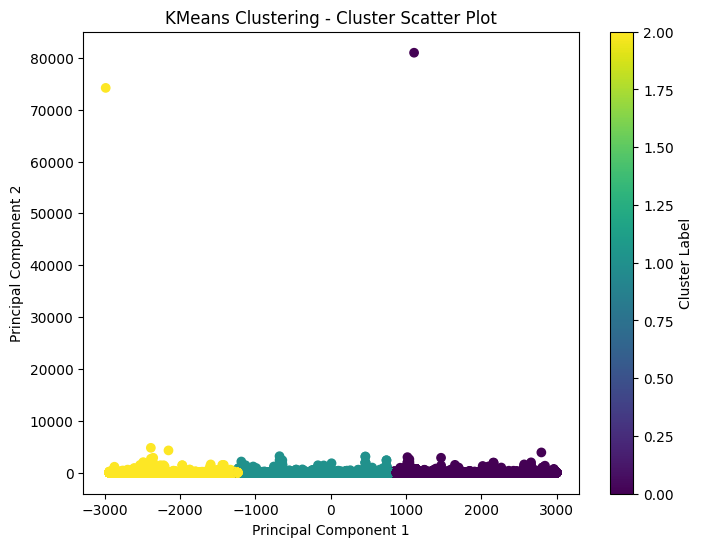

In [86]:
# 3. **Visualisasi KMeans Clustering (Cluster Scatter Plot)**
# Membuat scatter plot dari dua komponen utama (PCA untuk visualisasi 2D)
from sklearn.decomposition import PCA

# Gunakan PCA untuk mengurangi dimensi data menjadi 2 untuk visualisasi
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_cleaned_numeric)

# Visualisasi Clustering dengan Plot
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans_labels, cmap='viridis', label='Clusters')
plt.title('KMeans Clustering - Cluster Scatter Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# Tentukan jumlah cluster (n_clusters), ini bisa disesuaikan
n_clusters = 3  # Misalnya kita memilih 3 cluster untuk AgglomerativeClustering

# 1. **AgglomerativeClustering**
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
agg_labels = agg_clustering.fit_predict(data_cleaned_numeric)  # Gunakan data_cleaned_numeric untuk clustering

# 2. **Evaluasi Model AgglomerativeClustering**
# Menghitung metrik evaluasi
agg_silhouette = silhouette_score(data_cleaned_numeric, agg_labels)
agg_davies_bouldin = davies_bouldin_score(data_cleaned_numeric, agg_labels)
agg_calinski = calinski_harabasz_score(data_cleaned_numeric, agg_labels)

# Tampilkan hasil evaluasi
print(f"AgglomerativeClustering Silhouette Score: {agg_silhouette}")
print(f"AgglomerativeClustering Davies-Bouldin Index: {agg_davies_bouldin}")
print(f"AgglomerativeClustering Calinski-Harabasz Score: {agg_calinski}")

# 3. **Visualisasi AgglomerativeClustering (Cluster Scatter Plot)**
# Membuat scatter plot dari dua komponen utama (PCA untuk visualisasi 2D)
from sklearn.decomposition import PCA

# Gunakan PCA untuk mengurangi dimensi data menjadi 2 untuk visualisasi
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_cleaned_numeric)

# Visualisasi Clustering dengan Plot
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=agg_labels, cmap='viridis', label='Clusters')
plt.title('AgglomerativeClustering - Cluster Scatter Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# 1. **DBSCAN Clustering**
# DBSCAN tidak memerlukan jumlah cluster, hanya parameter 'eps' dan 'min_samples' yang perlu disesuaikan
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Sesuaikan 'eps' dan 'min_samples' jika diperlukan
dbscan_labels = dbscan.fit_predict(data_cleaned_numeric)

# 2. **Evaluasi Model DBSCAN**
# Perhatikan bahwa DBSCAN dapat menghasilkan label -1 untuk noise points, yang berarti tidak ada cluster
# Untuk menghitung metrik evaluasi, kita hanya menggunakan data yang memiliki label cluster valid
valid_labels = dbscan_labels != -1

# Menghitung metrik evaluasi
dbscan_silhouette = silhouette_score(data_cleaned_numeric[valid_labels], dbscan_labels[valid_labels]) if valid_labels.sum() > 1 else -1
dbscan_davies_bouldin = davies_bouldin_score(data_cleaned_numeric[valid_labels], dbscan_labels[valid_labels]) if valid_labels.sum() > 1 else -1
dbscan_calinski = calinski_harabasz_score(data_cleaned_numeric[valid_labels], dbscan_labels[valid_labels]) if valid_labels.sum() > 1 else -1

# Tampilkan hasil evaluasi
print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")
print(f"DBSCAN Davies-Bouldin Index: {dbscan_davies_bouldin}")
print(f"DBSCAN Calinski-Harabasz Score: {dbscan_calinski}")

# 3. **Visualisasi DBSCAN Clustering**
# Visualisasi Clustering dengan Plot (menggunakan PCA)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_cleaned_numeric)

plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=dbscan_labels, cmap='viridis', label='Clusters')
plt.title('DBSCAN Clustering - Cluster Scatter Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# 1. **Gaussian Mixture Model (GMM)**
gmm = GaussianMixture(n_components=3, random_state=42)  # Sesuaikan n_components sesuai jumlah cluster yang diinginkan
gmm_labels = gmm.fit_predict(data_cleaned_numeric)

# 2. **Evaluasi Model GMM**
gmm_silhouette = silhouette_score(data_cleaned_numeric, gmm_labels)
gmm_davies_bouldin = davies_bouldin_score(data_cleaned_numeric, gmm_labels)
gmm_calinski = calinski_harabasz_score(data_cleaned_numeric, gmm_labels)

# Tampilkan hasil evaluasi
print(f"GMM Silhouette Score: {gmm_silhouette}")
print(f"GMM Davies-Bouldin Index: {gmm_davies_bouldin}")
print(f"GMM Calinski-Harabasz Score: {gmm_calinski}")

# 3. **Visualisasi GMM Clustering**
# Visualisasi Clustering dengan Plot (menggunakan PCA)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_cleaned_numeric)

plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=gmm_labels, cmap='viridis', label='Clusters')
plt.title('GMM Clustering - Cluster Scatter Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# 1. **Spectral Clustering**
spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
spectral_labels = spectral.fit_predict(data_cleaned_numeric)

# 2. **Evaluasi Model SpectralClustering**
spectral_silhouette = silhouette_score(data_cleaned_numeric, spectral_labels)
spectral_davies_bouldin = davies_bouldin_score(data_cleaned_numeric, spectral_labels)
spectral_calinski = calinski_harabasz_score(data_cleaned_numeric, spectral_labels)

# Tampilkan hasil evaluasi
print(f"SpectralClustering Silhouette Score: {spectral_silhouette}")
print(f"SpectralClustering Davies-Bouldin Index: {spectral_davies_bouldin}")
print(f"SpectralClustering Calinski-Harabasz Score: {spectral_calinski}")

# 3. **Visualisasi SpectralClustering**
# Visualisasi Clustering dengan Plot (menggunakan PCA)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_cleaned_numeric)

plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=spectral_labels, cmap='viridis', label='Clusters')
plt.title('SpectralClustering - Cluster Scatter Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


## 3. Penjelasan

### 1. **K-Means Silhouette Score Rendah dan Inkonsistensi dengan Elbow Method**

* **Masalah**:

  * **Silhouette Score rendah (0.3)** meskipun **Elbow Method** menunjukkan **K=5** sebagai optimal. Hal ini menunjukkan bahwa meskipun jumlah cluster yang dihasilkan oleh **Elbow Method** tampaknya tepat secara visual, kualitas cluster yang terbentuk tidak optimal, yang mengarah pada nilai silhouette score yang rendah.
  * Salah satu penyebab utama inkonsistensi ini adalah **distribusi data yang non-spherical**. KMeans bekerja dengan asumsi bahwa data dalam cluster membentuk **bentuk bola** (spherical clusters) yang terpisah satu sama lain. Namun, jika data sebenarnya membentuk cluster dengan bentuk yang lebih kompleks (misalnya, bentuk elips atau memanjang), KMeans mungkin tidak dapat membedakan cluster secara efektif, mengarah pada nilai silhouette yang rendah meskipun jumlah cluster sudah optimal secara visual.

* **Strategi Validasi Alternatif**:

  * **Analisis Gap Statistic**: Mengukur perbedaan antara variansi clustering aktual dengan variansi clustering pada data acak (dengan distribusi yang tidak terstruktur). Gap Statistic dapat memberikan indikasi yang lebih kuat tentang jumlah cluster optimal karena mempertimbangkan variasi dalam data.
  * **Validasi Stabilitas Cluster via Bootstrapping**: Menggunakan teknik bootstrapping untuk mengambil sampel acak dari dataset dan memeriksa stabilitas hasil clustering di setiap iterasi. Jika cluster yang terbentuk stabil pada berbagai subset data, maka clustering tersebut lebih valid.

* **Mengapa Distribusi Non-Spherical Menjadi Masalah**:

  * KMeans menggunakan **jarak Euclidean** untuk memisahkan data ke dalam cluster. Ini membuat KMeans lebih cocok untuk data yang terdistribusi dalam bentuk **lingkaran atau bola**. Jika cluster data berbentuk **non-spherical** (misalnya, berbentuk memanjang atau berkelok), KMeans akan kesulitan memisahkan data dengan benar, sehingga hasil clustering yang buruk dan nilai silhouette yang rendah.

---

### 2. **Metode Preprocessing untuk Fitur Numerik dan Kategorikal High-Cardinality**

* **Fitur Numerik dan Kategorikal High-Cardinality**:

  * **Numerik**: **Quantity** dan **UnitPrice** dapat diproses dengan **standardisasi** atau **normalisasi** untuk menyelaraskan skala, menghindari dominasi fitur dengan skala besar pada model clustering.
  * **Kategorikal**: **Description** sebagai fitur kategorikal dengan banyak kategori (high-cardinality) membutuhkan representasi yang efisien.

* **Risiko Menggunakan One-Hot Encoding untuk Description**:

  * **One-Hot Encoding** untuk kolom **Description** akan menghasilkan banyak kolom biner (satu untuk setiap kategori unik), yang menyebabkan peningkatan **dimensi** yang sangat tinggi dan berisiko **sparse matrix** yang sulit diproses.
  * Selain itu, **One-Hot Encoding** tidak mempertimbangkan urutan atau kesamaan semantik antara kategori, sehingga hubungan semantik antar kategori **tidak tercapture**, yang dapat mengurangi kualitas clustering.

* **Teknik yang Lebih Robus**:

  * **TF-IDF**: Representasi teks ini memperhitungkan frekuensi kemunculan kata dalam suatu dokumen dan membandingkannya dengan frekuensi kata tersebut di seluruh dokumen. Ini lebih robust karena **mengurangi pengaruh kata-kata yang sering muncul di seluruh dataset** dan lebih menekankan kata-kata yang penting dalam konteks tertentu.
  * **Embedding Berdimensi Rendah (seperti UMAP)**: **Embedding teks** dalam ruang berdimensi rendah dengan teknik seperti **UMAP (Uniform Manifold Approximation and Projection)** memungkinkan representasi yang lebih kompak dan dapat **mempertahankan hubungan struktural** antar kategori. Teknik ini mengurangi dimensi secara efisien sambil menjaga hubungan semantik antar kategori.

---

### 3. **Menentukan Nilai Epsilon Optimal pada DBSCAN untuk Data Tidak Seimbang**

* **Masalah**: DBSCAN sangat sensitif terhadap parameter **epsilon** (eps) yang menentukan jarak maksimal antara titik dalam cluster. Data yang tidak seimbang (misalnya, 90% pelanggan dari UK) bisa menyebabkan DBSCAN gagal mendeteksi cluster yang padat dan menghasilkan banyak titik sebagai **noise**.

* **Menentukan Epsilon secara Adaptif**:

  * **K-Distance Graph**: Ini adalah teknik untuk menentukan nilai **epsilon** secara adaptif. Anda menghitung jarak ke titik terdekat **k** untuk setiap titik, kemudian menggambar grafik untuk melihat **"elbow"** atau perubahan tajam dalam jarak tersebut. **Epsilon** optimal adalah nilai pada titik ini, yang memisahkan titik yang sangat dekat dengan titik yang lebih jauh.
  * **Kuartil ke-3 (Q3)**: Dengan menggunakan **kuartil ke-3** dari jarak k-nearest neighbors, Anda bisa menentukan ambang batas di mana data yang lebih jauh dari nilai ini bisa dianggap sebagai **noise** dan tidak dimasukkan dalam cluster.

* **Mengapa MinPts Harus Disesuaikan**:

  * **MinPts** adalah jumlah minimum titik yang dibutuhkan untuk membentuk cluster. Jika data sangat tidak seimbang, **MinPts** harus disesuaikan berdasarkan kerapatan lokal dari cluster, terutama pada area yang lebih padat (misalnya, pelanggan di UK).

---

### 4. **Mengatasi Overlap antara Cluster "High-Value Customers" dan "Bulk Buyers"**

* **Masalah**: Jika cluster seperti **"high-value customers"** dan **"bulk buyers"** tumpang tindih berdasarkan total pengeluaran, mungkin ada kesulitan dalam memisahkan cluster menggunakan metode unsupervised seperti KMeans atau DBSCAN.

* **Teknik Semi-Supervised dan Integrasi Metric Learning**:

  * **Constrained Clustering (Semi-Supervised)**: Menggunakan **constraints** (seperti **must-link** atau **cannot-link** constraints) untuk memberi informasi tambahan pada model tentang data yang seharusnya tergabung dalam cluster yang sama atau berbeda.
  * **Integrasi Metric Learning**: **Mahalanobis distance** adalah jarak yang lebih fleksibel dibandingkan Euclidean. Dengan menggunakan **metric learning**, kita bisa mempelajari **metric jarak yang lebih sesuai** dengan struktur data dan pemisahan cluster.

* **Tantangan Interpretabilitas**:

  * **Metric Learning dan Non-Euclidean Spaces**: Menggunakan **Mahalanobis distance** atau pendekatan non-Euclidean lainnya bisa **mengurangi interpretabilitas**. **Jarak Mahalanobis** mengubah cara kita mengukur jarak antar titik, yang membuatnya lebih sulit untuk menjelaskan cluster berdasarkan intuisi bisnis biasa.

---

### 5. **Merancang Temporal Features untuk InvoiceDate dan Risiko Data Leakage**

* **Merancang Fitur Temporal**:

  * **Hari dalam Minggu** dan **Jam Pembelian**: Dapat diambil dari kolom **InvoiceDate** untuk mengidentifikasi pola pembelian periodik, seperti transaksi pagi vs. malam.
  * **Fitur Waktu**: `data_cleaned['InvoiceDate'].dt.weekday` untuk hari dalam minggu, dan `data_cleaned['InvoiceDate'].dt.hour` untuk jam pembelian.

* **Risiko Data Leakage**:

  * **Data Leakage** dapat terjadi jika **agregasi temporal** (misalnya, rata-rata pembelian bulanan) dilakukan pada data yang mencakup **informasi masa depan**. Untuk menghindari ini, kita harus menggunakan **time-based cross-validation** untuk memastikan bahwa model hanya melihat data yang sudah tersedia pada saat pembelian (tidak menggunakan data masa depan).

* **Lag Features**:

  * **Lag Features** (misalnya, pembelian 7 hari sebelumnya) dapat menambah **noise** karena **periode waktu yang lebih panjang** mungkin tidak relevan untuk cluster tertentu. Penggunaan **lag features** bisa memperkenalkan fluktuasi yang tidak mencerminkan pola yang sebenarnya, sehingga mengaburkan hasil clustering.

